100%|██████████| 170M/170M [09:10<00:00, 310kB/s]  
c:\Users\USERAS\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Epoch 1: Loss=0.0391
Epoch 2: Loss=0.0364
Epoch 3: Loss=0.0363
Epoch 4: Loss=0.0386
Epoch 5: Loss=0.0317
Epoch 6: Loss=0.0369
Epoch 7: Loss=0.0366
Epoch 8: Loss=0.0361
Epoch 9: Loss=0.0360
Epoch 10: Loss=0.0337


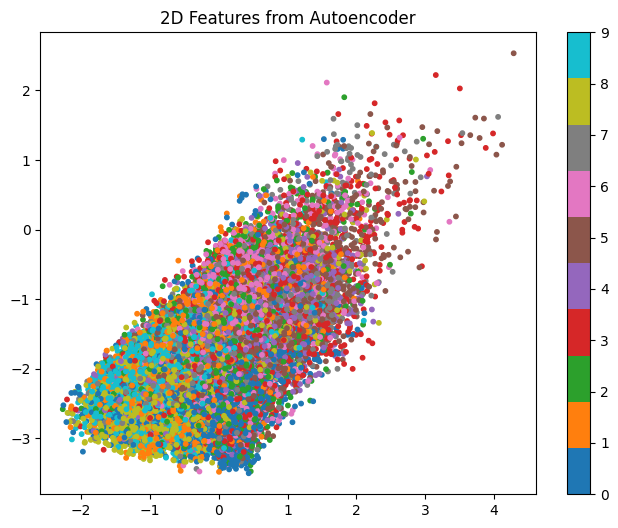

In [1]:
import torch, torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

# --- Data ---
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

# --- Autoencoder ---
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2D latent
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 32*32*3),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 32, 32))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Train ---
for epoch in range(10):
    for img, _ in train_loader:
        img = img.cuda()
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")

# --- Visualize 2D latent features ---
model.eval()
features, labels = [], []
with torch.no_grad():
    for img, label in train_loader:
        z = model.encoder(img.cuda()).cpu().numpy()
        features.append(z)
        labels.extend(label.numpy())

features = np.concatenate(features)
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("2D Features from Autoencoder")
plt.show()


c:\Users\USERAS\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USERAS\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USERAS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:56<00:00, 834kB/s] 


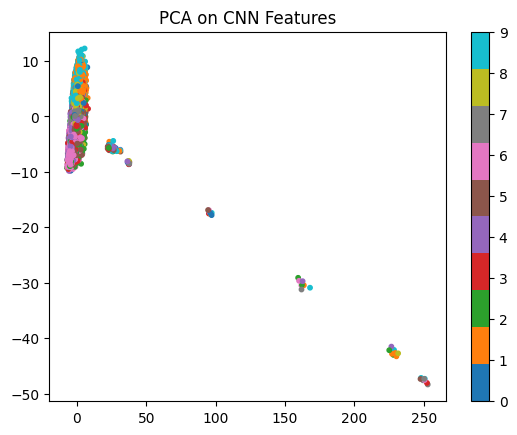

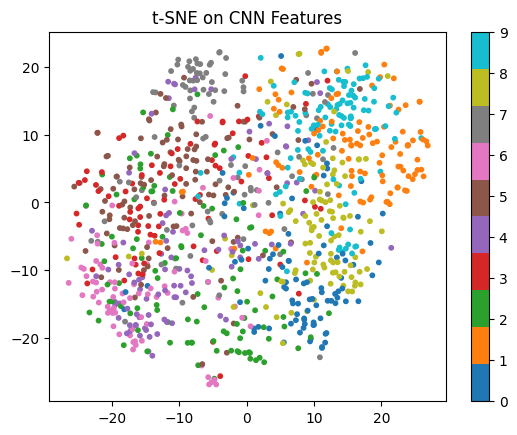

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision.models import resnet18

# Pretrained CNN
resnet = resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC
resnet.eval().cuda()

# Get features
features_cnn, labels = [], []
with torch.no_grad():
    for img, label in train_loader:
        img_resized = nn.functional.interpolate(img, size=(224, 224))
        feat = resnet(img_resized.cuda()).squeeze().cpu().numpy()
        features_cnn.append(feat)
        labels.extend(label.numpy())
features_cnn = np.vstack(features_cnn)

# PCA
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(features_cnn)

# t-SNE
tsne_feat = TSNE(n_components=2, perplexity=30).fit_transform(features_cnn[:1000])
label_sample = labels[:1000]

# Plot PCA
plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c=labels, cmap='tab10', s=10)
plt.title("PCA on CNN Features")
plt.colorbar()
plt.show()

# Plot t-SNE
plt.scatter(tsne_feat[:, 0], tsne_feat[:, 1], c=label_sample, cmap='tab10', s=10)
plt.title("t-SNE on CNN Features")
plt.colorbar()
plt.show()


In [3]:
class DenoisingAutoencoder(Autoencoder):
    def forward(self, x):
        noise = torch.randn_like(x) * 0.2
        x_noisy = x + noise
        x_noisy = torch.clamp(x_noisy, 0., 1.)
        z = self.encoder(x_noisy)
        x_recon = self.decoder(z)
        return x_recon

denoise_model = DenoisingAutoencoder().cuda()
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=1e-3)

# Training
for epoch in range(10):
    for img, _ in train_loader:
        img = img.cuda()
        output = denoise_model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")


Epoch 1: Loss=0.0407
Epoch 2: Loss=0.0329
Epoch 3: Loss=0.0368
Epoch 4: Loss=0.0362
Epoch 5: Loss=0.0349
Epoch 6: Loss=0.0372
Epoch 7: Loss=0.0368
Epoch 8: Loss=0.0375
Epoch 9: Loss=0.0358
Epoch 10: Loss=0.0371


In [4]:
import torch.nn.functional as F

# Data (no augmentation)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=64)

# Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x): return self.net(x)

model = SimpleCNN().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training
for epoch in range(10):
    model.train()
    for img, label in train_loader:
        img, label = img.cuda(), label.cuda()
        pred = model(img)
        loss = loss_fn(pred, label)
        opt.zero_grad()
        loss.backward()
        opt.step()
    print(f"Epoch {epoch+1}, Loss={loss.item():.4f}")


Epoch 1, Loss=0.8129
Epoch 2, Loss=1.1533
Epoch 3, Loss=0.8942
Epoch 4, Loss=1.5500
Epoch 5, Loss=0.4560
Epoch 6, Loss=0.5177
Epoch 7, Loss=0.2230
Epoch 8, Loss=0.3149
Epoch 9, Loss=0.2333
Epoch 10, Loss=0.0871


In [5]:
# Augmented transforms
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

train_aug_data = datasets.CIFAR10(root='./data', train=True, transform=aug_transform)
train_aug_loader = DataLoader(train_aug_data, batch_size=64, shuffle=True)

model_aug = SimpleCNN().cuda()
opt_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-3)

# Training with augmentation
for epoch in range(10):
    model_aug.train()
    for img, label in train_aug_loader:
        img, label = img.cuda(), label.cuda()
        pred = model_aug(img)
        loss = loss_fn(pred, label)
        opt_aug.zero_grad()
        loss.backward()
        opt_aug.step()
    print(f"Augmented Epoch {epoch+1}, Loss={loss.item():.4f}")


Augmented Epoch 1, Loss=1.1303
Augmented Epoch 2, Loss=1.0149
Augmented Epoch 3, Loss=1.0962
Augmented Epoch 4, Loss=1.1895
Augmented Epoch 5, Loss=1.2887
Augmented Epoch 6, Loss=0.8000
Augmented Epoch 7, Loss=0.5397
Augmented Epoch 8, Loss=1.2875
Augmented Epoch 9, Loss=0.6455
Augmented Epoch 10, Loss=1.3412
